In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from time import time
from functools import reduce
import matplotlib.pyplot as plt

# Sklearn
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Own Liberay

# PCR - Principal component regression

## Data processing


In [4]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

### 1. Load data

In [6]:
# Import features
file_path = 'Merged_dataset.csv'
df = pd.read_csv("merged_dataset.csv", sep=";", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.shape

(156, 184)

In [7]:
y = df.iloc[:, 0]   # første kolonne = inflation
X = df.iloc[:, 1:]  # resten = forklarende variable

# Tjek dimensioner
print("y shape:", y.shape)
print("X shape:", X.shape)

y shape: (156,)
X shape: (156, 183)


### 2. Imputer manglende værdier

In [9]:
imputer = SimpleImputer(strategy="median")  # Eller "median"

X_imputed = imputer.fit_transform(X)  # Imputer NaN i hele datasættet

# Konverter tilbage til DataFrame med kolonnenavne
X = pd.DataFrame(X_imputed, columns=X.columns, index = df.index)

### 3. Standardiser data 

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Simple Forcasting model

In [13]:
def PCR_Forecaster(X, y, forecast_horizon, last_observation_date, scaler, variance_threshold=0.95, verbose=True):
    """
    Forecast inflation using Principal Component Regression (PCR) per forecast horizon.
    
    Args:
        X: DataFrame of predictors
        y: Series of target
        forecast_horizon: int, number of months ahead
        last_observation_date: str or Timestamp, point to forecast from
        scaler: fitted StandardScaler on training data
        variance_threshold: float, % of explained variance to retain (default: 0.95)
        verbose: print training info
    """

    # Trim data til real-time
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]

    X_scaled = scaler.transform(X)
    
    pcr_models = {}

    for h in range(forecast_horizon):
        if verbose:
            print(f"\n=== Horisont h={h} ===")

        y_shifted = y.shift(-h).dropna()
        X_train = X_scaled[:len(y_shifted)]
        y_train = y_shifted

        # Automatisk valg af antal komponenter
        pca = PCA().fit(X_train)
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumvar >= variance_threshold) + 1

        if verbose:
            print(f"Forklaret varians (k={n_components}): {cumvar[n_components-1]:.2%}")
            
        # PCR pipeline
        model = Pipeline([
            ("pca", PCA(n_components=n_components)),
            ("reg", LinearRegression())
        ])

        model.fit(X_train, y_train)
        pcr_models[h] = model

        if verbose:
            print(f"Træningsobs: {len(y_train)} | Komponenter: {n_components}")

    # Forudsig fra X_t
    try:
        X_t = X.loc[[last_observation_date]]
    except KeyError:
        X_t = X.iloc[[-1]]
        if verbose:
            print(f"Dato {last_observation_date} ikke i X, bruger {X.index[-1]} i stedet.")

    X_t_scaled = scaler.transform(X_t)

    # Forudsig
    pcr_forecasts = {}
    for h in range(forecast_horizon):
        forecast = pcr_models[h].predict(X_t_scaled)
        pcr_forecasts[h] = forecast[0]

    # Lav datoer
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in pcr_forecasts.keys()]

    #  Print datoer for de forudsagte måneder
    print("\nForudsagte måneder:")
    for date in forecast_dates:
        print(date.strftime("%Y-%m"))
        
    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(pcr_forecasts.values()),
        "Horizon": list(pcr_forecasts.keys())
    })

    return forecast_df

In [14]:
# Lav forecast fra sidste kendte måned
forecast_df = PCR_Forecaster(
    X=X,
    y=y,
    forecast_horizon=12,
    last_observation_date="2024-12-01",
    scaler=scaler,
    variance_threshold=0.995
)


=== Horisont h=0 ===
Forklaret varians (k=45): 99.53%
Træningsobs: 156 | Komponenter: 45

=== Horisont h=1 ===
Forklaret varians (k=45): 99.52%
Træningsobs: 155 | Komponenter: 45

=== Horisont h=2 ===
Forklaret varians (k=44): 99.51%
Træningsobs: 154 | Komponenter: 44

=== Horisont h=3 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 153 | Komponenter: 44

=== Horisont h=4 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 152 | Komponenter: 44

=== Horisont h=5 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 151 | Komponenter: 44

=== Horisont h=6 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 150 | Komponenter: 44

=== Horisont h=7 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 149 | Komponenter: 44

=== Horisont h=8 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 148 | Komponenter: 44

=== Horisont h=9 ===
Forklaret varians (k=44): 99.53%
Træningsobs: 147 | Komponenter: 44

=== Horisont h=10 ===
Forklaret varians (k=44): 99.52%
Træningsobs: 146 | Komponenter: 44

=== Hori

# Implement of a rolling window

In [16]:
def pcr_forecast_rolling(X, y, forecast_horizon, last_observation_date, scaler, variance_threshold=0.95,window_length=108, verbose=True):
    """
    Forecast inflation using Principal Component Regression (PCR) per forecast horizon.
    
    Args:
        X: DataFrame of predictors
        y: Series of target
        forecast_horizon: int, number of months ahead
        last_observation_date: str or Timestamp, point to forecast from
        scaler: fitted StandardScaler on training data
        variance_threshold: float, % of explained variance to retain (default: 0.95)
        verbose: print training info
    """

    # Trim data til real-time
    X_init = X.loc[:last_observation_date]
    y_init = y.loc[:last_observation_date]
    
    X = X_init.iloc[-window_length:]
    y = y_init.iloc[-window_length:]

    X_scaled = scaler.transform(X)
    
    pcr_models = {}

    for h in range(forecast_horizon):
        if verbose:
            print(f"\n=== Horisont h={h} ===")

        y_shifted = y.shift(-h).dropna()
        X_train = X_scaled[:len(y_shifted)]
        y_train = y_shifted

        # Automatisk valg af antal komponenter
        pca = PCA().fit(X_train)
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        n_components = np.argmax(cumvar >= variance_threshold) + 1

        if verbose:
            print(f"Forklaret varians (k={n_components}): {cumvar[n_components-1]:.2%}")
            
        # PCR pipeline
        model = Pipeline([
            ("pca", PCA(n_components=n_components)),
            ("reg", LinearRegression())
        ])

        model.fit(X_train, y_train)
        pcr_models[h] = model

        if verbose:
            print(f"Træningsobs: {len(y_train)} | Komponenter: {n_components}")

    # Forudsig fra X_t
    try:
        X_t = X.loc[[last_observation_date]]
    except KeyError:
        X_t = X.iloc[[-1]]
        if verbose:
            print(f"Dato {last_observation_date} ikke i X, bruger {X.index[-1]} i stedet.")

    X_t_scaled = scaler.transform(X_t)

    # Forudsig
    pcr_forecasts = {}
    for h in range(forecast_horizon):
        forecast = pcr_models[h].predict(X_t_scaled)
        pcr_forecasts[h] = forecast[0]

    # Lav datoer
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in pcr_forecasts.keys()]

    if verbose:
        #  Print datoer for de forudsagte måneder
        print("\nForudsagte måneder:")
        for date in forecast_dates:
            print(date.strftime("%Y-%m"))
        
    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(pcr_forecasts.values()),
        "Horizon": list(pcr_forecasts.keys())
    })

    return forecast_df

In [17]:
df_pcr_forecast_rolling  = pcr_forecast_rolling(X=X, 
                      y=y, 
                      forecast_horizon = 12, 
                      last_observation_date="2024-12-01", 
                      scaler=scaler, 
                      window_length=108,
                      variance_threshold=0.999, 
                      verbose=True)


=== Horisont h=0 ===
Forklaret varians (k=59): 99.91%
Træningsobs: 108 | Komponenter: 59

=== Horisont h=1 ===
Forklaret varians (k=58): 99.90%
Træningsobs: 107 | Komponenter: 58

=== Horisont h=2 ===
Forklaret varians (k=58): 99.91%
Træningsobs: 106 | Komponenter: 58

=== Horisont h=3 ===
Forklaret varians (k=57): 99.90%
Træningsobs: 105 | Komponenter: 57

=== Horisont h=4 ===
Forklaret varians (k=57): 99.90%
Træningsobs: 104 | Komponenter: 57

=== Horisont h=5 ===
Forklaret varians (k=57): 99.91%
Træningsobs: 103 | Komponenter: 57

=== Horisont h=6 ===
Forklaret varians (k=56): 99.90%
Træningsobs: 102 | Komponenter: 56

=== Horisont h=7 ===
Forklaret varians (k=56): 99.90%
Træningsobs: 101 | Komponenter: 56

=== Horisont h=8 ===
Forklaret varians (k=56): 99.91%
Træningsobs: 100 | Komponenter: 56

=== Horisont h=9 ===
Forklaret varians (k=55): 99.90%
Træningsobs: 99 | Komponenter: 55

=== Horisont h=10 ===
Forklaret varians (k=55): 99.90%
Træningsobs: 98 | Komponenter: 55

=== Horiso

In [18]:
df_pcr_forecast_rolling

,Dato,Inflationsforecast,Horizon
0,2025-01-01,1.740013,0
1,2025-02-01,2.336593,1
2,2025-03-01,1.886154,2
3,2025-04-01,2.883629,3
4,2025-05-01,2.298175,4
5,2025-06-01,2.807872,5
6,2025-07-01,3.365108,6
7,2025-08-01,2.988776,7
8,2025-09-01,2.681785,8
9,2025-10-01,3.175845,9


# Forcasting model with a rolling window

In [20]:
def run_rolling_forecast(X, y, forecast_horizon=12, start_date="2012-01", end_date="2015-12", window_length=72):
    """
    Kører rolling real-time forecast med Random Forest, én forecast per måned (med 12 horisonter per gang)
    """

    all_forecasts = []

    forecast_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

    for date in forecast_dates:
        print(f"\n=== Forecast lavet i: {date.strftime('%Y-%m')} ===")

        # Real-time datasæt
        X_train = X.loc[:date]
        y_train = y.loc[:date]

        if len(X_train) < window_length:
            print("Springer over pga. for lidt data.")
            continue

        # Skaler træningsdata (rolling window)
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[-window_length:])

        # Lav forecast for 12 horisonter
        forecast_df = pcr_forecast_rolling(
            X=X,
            y=y,
            forecast_horizon=forecast_horizon,
            last_observation_date=date,
            scaler=scaler,
            window_length=window_length, 
            variance_threshold=0.99,
            verbose=False
        )

        forecast_df["Forecast_made_in"] = date  # hvornår forecast blev lavet
        all_forecasts.append(forecast_df)

    all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)
    return all_forecasts_df

In [21]:
forecast_results = run_rolling_forecast(X, y, forecast_horizon=12, start_date="2023-01-01", end_date="2024-12-01")


=== Forecast lavet i: 2023-01 ===

=== Forecast lavet i: 2023-02 ===

=== Forecast lavet i: 2023-03 ===

=== Forecast lavet i: 2023-04 ===

=== Forecast lavet i: 2023-05 ===

=== Forecast lavet i: 2023-06 ===

=== Forecast lavet i: 2023-07 ===

=== Forecast lavet i: 2023-08 ===

=== Forecast lavet i: 2023-09 ===

=== Forecast lavet i: 2023-10 ===

=== Forecast lavet i: 2023-11 ===

=== Forecast lavet i: 2023-12 ===

=== Forecast lavet i: 2024-01 ===

=== Forecast lavet i: 2024-02 ===

=== Forecast lavet i: 2024-03 ===

=== Forecast lavet i: 2024-04 ===

=== Forecast lavet i: 2024-05 ===

=== Forecast lavet i: 2024-06 ===

=== Forecast lavet i: 2024-07 ===

=== Forecast lavet i: 2024-08 ===

=== Forecast lavet i: 2024-09 ===

=== Forecast lavet i: 2024-10 ===

=== Forecast lavet i: 2024-11 ===

=== Forecast lavet i: 2024-12 ===


In [22]:
forecast_results

,Dato,Inflationsforecast,Horizon,Forecast_made_in
0,2023-02-01,7.867999,0,2023-01-01
1,2023-03-01,8.659082,1,2023-01-01
2,2023-04-01,8.518868,2,2023-01-01
3,2023-05-01,7.916939,3,2023-01-01
4,2023-06-01,7.596172,4,2023-01-01
...,...,...,...,...
283,2025-08-01,1.016695,7,2024-12-01
284,2025-09-01,0.314246,8,2024-12-01
285,2025-10-01,0.793871,9,2024-12-01
286,2025-11-01,0.568461,10,2024-12-01


In [23]:
def evaluate_forecasts(forecast_df, y):
    """
    Matcher forecast med y_true og returnerer RMSE og MAE pr. horisont
    """
    # Merge forecast og faktisk inflation
    merged = forecast_df.merge(
        y.rename("y_true"), 
        left_on="Dato", 
        right_index=True,
        how="left"
    )

    # Filtrer ud fremtid hvor vi ikke har faktisk inflation
    merged = merged.dropna(subset=["y_true"])

    # Beregn fejl
    merged["error"] = merged["Inflationsforecast"] - merged["y_true"]
    merged["abs_error"] = merged["error"].abs()
    merged["squared_error"] = merged["error"] ** 2

    # Evaluer pr. horisont
    evaluation = merged.groupby("Horizon").agg(
        MAE=("abs_error", "mean"),
        RMSE=("squared_error", lambda x: (x.mean())**0.5),
        N_obs=("y_true", "count")
    ).reset_index()

    return evaluation, merged


In [24]:
eval_df, merged_df = evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.754384,1.028924,23
1,1,1.125243,1.555982,22
2,2,1.523041,2.042998,21
3,3,1.752481,2.298045,20
4,4,1.789426,2.302476,19
5,5,1.405971,2.021613,18
6,6,1.520779,2.147911,17
7,7,1.939631,2.754972,16
8,8,2.066118,3.191862,15
9,9,2.554859,3.819151,14


In [25]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,7.867999,0,2023-01-01,7.601,0.266999,0.266999,0.071289
12,2023-03-01,7.613462,0,2023-02-01,6.733,0.880462,0.880462,0.775213
24,2023-04-01,7.171414,0,2023-03-01,5.282,1.889414,1.889414,3.569886
36,2023-05-01,5.459550,0,2023-04-01,2.928,2.531550,2.531550,6.408743
48,2023-06-01,3.835357,0,2023-05-01,2.465,1.370357,1.370357,1.877878
60,2023-07-01,2.707958,0,2023-06-01,3.133,-0.425042,0.425042,0.180661
72,2023-08-01,3.078376,0,2023-07-01,2.437,0.641376,0.641376,0.411364
84,2023-09-01,2.567361,0,2023-08-01,0.859,1.708361,1.708361,2.918496
96,2023-10-01,1.768479,0,2023-09-01,0.085,1.683479,1.683479,2.834103
108,2023-11-01,0.751157,0,2023-10-01,0.600,0.151157,0.151157,0.022849


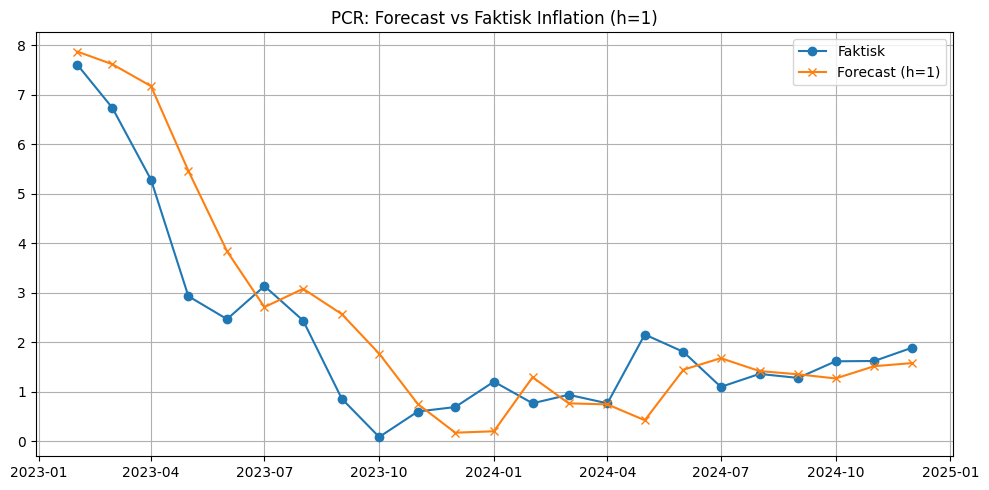

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Dato"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Dato"], h1["Inflationsforecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("PCR: Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()